In [4]:
import numpy as np
import keras
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

In [5]:
from imblearn.over_sampling import RandomOverSampler
lfw_people = fetch_lfw_people(min_faces_per_person=25, funneled=True, color=True, resize=1.0,
                              slice_=(slice(48, 202), slice(48, 202)))

X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print('number of examples: {}'.format(y.shape[0]))
print('dimensionality of images: {}'.format(X.shape[1:]))
print('number of unique classes (people): {}'.format(n_classes))

number of examples: 2588
dimensionality of images: (154, 154, 3)
number of unique classes (people): 42


In [3]:
print(target_names)

['Alejandro Toledo' 'Alvaro Uribe' 'Andre Agassi' 'Ariel Sharon'
 'Arnold Schwarzenegger' 'Bill Clinton' 'Colin Powell' 'David Beckham'
 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Gloria Macapagal Arroyo' 'Gray Davis' 'Guillermo Coria' 'Hans Blix'
 'Hugo Chavez' 'Jack Straw' 'Jacques Chirac' 'Jean Chretien'
 'Jennifer Capriati' 'John Ashcroft' 'John Negroponte'
 'Juan Carlos Ferrero' 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush'
 'Lleyton Hewitt' 'Luiz Inacio Lula da Silva' 'Mahmoud Abbas'
 'Megawati Sukarnoputri' 'Nestor Kirchner' 'Recep Tayyip Erdogan'
 'Ricardo Lagos' 'Roh Moo-hyun' 'Rudolph Giuliani' 'Serena Williams'
 'Silvio Berlusconi' 'Tom Daschle' 'Tom Ridge' 'Tony Blair' 'Vicente Fox'
 'Vladimir Putin']


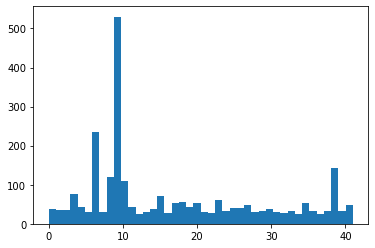

In [4]:
_ = plt.hist(y, bins=n_classes)

In [5]:
from keras.layers import Input
from keras.layers import Conv2D, GlobalAvgPool2D
from keras.layers import Dropout, Activation

input = Input(shape=X.shape[1:])                                  # 154x154x3
x = Conv2D(12, (3, 3), padding='same', activation='relu')(input)  # 154x154x12
x = Conv2D(12, (2, 2), strides=(2, 2), activation='relu')(x)      # 77x77x12
x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)      # 77x77x16
x = Conv2D(16, (2, 2), strides=(2, 2), activation='relu')(x)      # 38x38x16
x = Conv2D(24, (3, 3), padding='same', activation='relu')(x)      # 38x38x24
x = Conv2D(24, (2, 2), strides=(2, 2), activation='relu')(x)      # 19x19x24
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)      # 19x19x32
x = Conv2D(32, (2, 2), strides=(2, 2), activation='relu')(x)      # 9x9x32
x = Conv2D(48, (3, 3), padding='same', activation='relu')(x)      # 9x9x48
x = Conv2D(48, (2, 2), strides=(2, 2), activation='relu')(x)      # 4x4x48
x = Dropout(0.5)(x)                                               # 4x4x48
x = Conv2D(n_classes, (1, 1))(x)                                  # 4x4x62
x = GlobalAvgPool2D()(x)                                          # 62
output = Activation('softmax')(x)                                 # 62

In [6]:
from keras.models import Model
model = Model(inputs=input, outputs=output)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 154, 154, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 154, 154, 12)      336       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 12)        588       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 77, 77, 16)        1744      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 38, 38, 16)        1040      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 38, 38, 24)        3480      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 19, 19, 24)       

In [7]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1)

In [8]:
from keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

batch_size = 256
test_split = 0.25
base_lr = 0.001
epochs = 600

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, 
                                                    stratify=y, random_state=42)

# encoding of labels
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

# compile model and define optimization
model = Model(inputs=input, outputs=output)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Nadam(lr=base_lr),
              metrics=['accuracy'])

model_path = "C:/Users/vaibh/LFW_Face_Recognition/CNN-classes=42_funneled_UPDATED.h5"

# Model Checkpoint:
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

# model training
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/600
8/7 [===============================] - ETA: 0s - loss: 3.6481 - accuracy: 0.1334
Epoch 00001: val_accuracy improved from -inf to 0.20556, saving model to C:/Users/vaibh/LFW_Face_Recognition\CNN-classes=42_funneled_UPDATED.h5
8/7 [===============================] - 15s 2s/step - loss: 3.6481 - accuracy: 0.1334 - val_loss: 4.1313 - val_accuracy: 0.2056
Epoch 2/600
8/7 [===============================] - ETA: 0s - loss: 3.5659 - accuracy: 0.2045
Epoch 00002: val_accuracy did not improve from 0.20556
8/7 [===============================] - 15s 2s/step - loss: 3.5659 - accuracy: 0.2045 - val_loss: 3.3624 - val_accuracy: 0.2056
Epoch 3/600
8/7 [===============================] - ETA: 0s - loss: 3.3675 - accuracy: 0.2045
Epoch 00003: val_accuracy did not improve from 0.20556
8/7 [===============================] - 15s 2s/step - loss: 3.3675 - accuracy: 0.2045 - val_loss: 3.3114 - val_accuracy: 0.2056
Epoc

Epoch 27/600
8/7 [===============================] - ETA: 0s - loss: 2.9270 - accuracy: 0.2401
Epoch 00027: val_accuracy improved from 0.25811 to 0.26121, saving model to C:/Users/vaibh/LFW_Face_Recognition\CNN-classes=42_funneled_UPDATED.h5
8/7 [===============================] - 14s 2s/step - loss: 2.9270 - accuracy: 0.2401 - val_loss: 2.8226 - val_accuracy: 0.2612
Epoch 28/600
8/7 [===============================] - ETA: 0s - loss: 2.8659 - accuracy: 0.2370
Epoch 00028: val_accuracy did not improve from 0.26121
8/7 [===============================] - 14s 2s/step - loss: 2.8659 - accuracy: 0.2370 - val_loss: 2.8086 - val_accuracy: 0.2427
Epoch 29/600
8/7 [===============================] - ETA: 0s - loss: 2.9060 - accuracy: 0.2375
Epoch 00029: val_accuracy did not improve from 0.26121
8/7 [===============================] - 15s 2s/step - loss: 2.9060 - accuracy: 0.2375 - val_loss: 2.7018 - val_accuracy: 0.2566
Epoch 30/600
8/7 [===============================] - ETA: 0s - loss: 2.900

Epoch 80/600
8/7 [===============================] - ETA: 0s - loss: 2.1072 - accuracy: 0.4127
Epoch 00080: val_accuracy improved from 0.49614 to 0.52087, saving model to C:/Users/vaibh/LFW_Face_Recognition\CNN-classes=42_funneled_UPDATED.h5
8/7 [===============================] - 15s 2s/step - loss: 2.1072 - accuracy: 0.4127 - val_loss: 1.7878 - val_accuracy: 0.5209
Epoch 81/600
8/7 [===============================] - ETA: 0s - loss: 1.9940 - accuracy: 0.4189
Epoch 00081: val_accuracy did not improve from 0.52087
8/7 [===============================] - 14s 2s/step - loss: 1.9940 - accuracy: 0.4189 - val_loss: 1.8615 - val_accuracy: 0.4930
Epoch 82/600
8/7 [===============================] - ETA: 0s - loss: 1.9641 - accuracy: 0.4420
Epoch 00082: val_accuracy did not improve from 0.52087
8/7 [===============================] - 14s 2s/step - loss: 1.9641 - accuracy: 0.4420 - val_loss: 1.8698 - val_accuracy: 0.4915
Epoch 83/600
8/7 [===============================] - ETA: 0s - loss: 1.988

8/7 [===============================] - ETA: 0s - loss: 1.2351 - accuracy: 0.6342
Epoch 00135: val_accuracy did not improve from 0.71252
8/7 [===============================] - 14s 2s/step - loss: 1.2351 - accuracy: 0.6342 - val_loss: 1.0920 - val_accuracy: 0.6739
Epoch 136/600
8/7 [===============================] - ETA: 0s - loss: 1.2478 - accuracy: 0.6342
Epoch 00136: val_accuracy did not improve from 0.71252
8/7 [===============================] - 15s 2s/step - loss: 1.2478 - accuracy: 0.6342 - val_loss: 1.0442 - val_accuracy: 0.6971
Epoch 137/600
8/7 [===============================] - ETA: 0s - loss: 1.2231 - accuracy: 0.6399
Epoch 00137: val_accuracy did not improve from 0.71252
8/7 [===============================] - 14s 2s/step - loss: 1.2231 - accuracy: 0.6399 - val_loss: 1.0384 - val_accuracy: 0.6940
Epoch 138/600
8/7 [===============================] - ETA: 0s - loss: 1.1259 - accuracy: 0.6656
Epoch 00138: val_accuracy did not improve from 0.71252
8/7 [=====================

Epoch 164/600
8/7 [===============================] - ETA: 0s - loss: 0.9968 - accuracy: 0.6955
Epoch 00164: val_accuracy did not improve from 0.75116
8/7 [===============================] - 15s 2s/step - loss: 0.9968 - accuracy: 0.6955 - val_loss: 0.8876 - val_accuracy: 0.7481
Epoch 165/600
8/7 [===============================] - ETA: 0s - loss: 0.9873 - accuracy: 0.7105
Epoch 00165: val_accuracy did not improve from 0.75116
8/7 [===============================] - 14s 2s/step - loss: 0.9873 - accuracy: 0.7105 - val_loss: 0.8548 - val_accuracy: 0.7434
Epoch 166/600
8/7 [===============================] - ETA: 0s - loss: 0.9190 - accuracy: 0.7326
Epoch 00166: val_accuracy did not improve from 0.75116
8/7 [===============================] - 15s 2s/step - loss: 0.9190 - accuracy: 0.7326 - val_loss: 1.0493 - val_accuracy: 0.7156
Epoch 167/600
8/7 [===============================] - ETA: 0s - loss: 0.9779 - accuracy: 0.7058
Epoch 00167: val_accuracy did not improve from 0.75116
8/7 [=======

Epoch 219/600
8/7 [===============================] - ETA: 0s - loss: 0.6975 - accuracy: 0.7862
Epoch 00219: val_accuracy did not improve from 0.80525
8/7 [===============================] - 14s 2s/step - loss: 0.6975 - accuracy: 0.7862 - val_loss: 0.7127 - val_accuracy: 0.8006
Epoch 220/600
8/7 [===============================] - ETA: 0s - loss: 0.7441 - accuracy: 0.7702
Epoch 00220: val_accuracy did not improve from 0.80525
8/7 [===============================] - 14s 2s/step - loss: 0.7441 - accuracy: 0.7702 - val_loss: 0.7604 - val_accuracy: 0.7790
Epoch 221/600
8/7 [===============================] - ETA: 0s - loss: 0.6379 - accuracy: 0.8078
Epoch 00221: val_accuracy did not improve from 0.80525
8/7 [===============================] - 15s 2s/step - loss: 0.6379 - accuracy: 0.8078 - val_loss: 0.6825 - val_accuracy: 0.8053
Epoch 222/600
8/7 [===============================] - ETA: 0s - loss: 0.6743 - accuracy: 0.7888
Epoch 00222: val_accuracy improved from 0.80525 to 0.80680, saving 

8/7 [===============================] - ETA: 0s - loss: 0.5342 - accuracy: 0.8331
Epoch 00247: val_accuracy improved from 0.81917 to 0.82071, saving model to C:/Users/vaibh/LFW_Face_Recognition\CNN-classes=42_funneled_UPDATED.h5
8/7 [===============================] - 14s 2s/step - loss: 0.5342 - accuracy: 0.8331 - val_loss: 0.6486 - val_accuracy: 0.8207
Epoch 248/600
8/7 [===============================] - ETA: 0s - loss: 0.5296 - accuracy: 0.8305
Epoch 00248: val_accuracy improved from 0.82071 to 0.82226, saving model to C:/Users/vaibh/LFW_Face_Recognition\CNN-classes=42_funneled_UPDATED.h5
8/7 [===============================] - 15s 2s/step - loss: 0.5296 - accuracy: 0.8305 - val_loss: 0.6797 - val_accuracy: 0.8223
Epoch 249/600
8/7 [===============================] - ETA: 0s - loss: 0.6219 - accuracy: 0.8053
Epoch 00249: val_accuracy did not improve from 0.82226
8/7 [===============================] - 14s 2s/step - loss: 0.6219 - accuracy: 0.8053 - val_loss: 0.6335 - val_accuracy: 

Epoch 275/600
8/7 [===============================] - ETA: 0s - loss: 0.5218 - accuracy: 0.8279
Epoch 00275: val_accuracy did not improve from 0.83462
8/7 [===============================] - 15s 2s/step - loss: 0.5218 - accuracy: 0.8279 - val_loss: 0.6105 - val_accuracy: 0.8300
Epoch 276/600
8/7 [===============================] - ETA: 0s - loss: 0.4575 - accuracy: 0.8521
Epoch 00276: val_accuracy did not improve from 0.83462
8/7 [===============================] - 15s 2s/step - loss: 0.4575 - accuracy: 0.8521 - val_loss: 0.6264 - val_accuracy: 0.8145
Epoch 277/600
8/7 [===============================] - ETA: 0s - loss: 0.5134 - accuracy: 0.8449
Epoch 00277: val_accuracy did not improve from 0.83462
8/7 [===============================] - 14s 2s/step - loss: 0.5134 - accuracy: 0.8449 - val_loss: 0.8866 - val_accuracy: 0.7697
Epoch 278/600
8/7 [===============================] - ETA: 0s - loss: 0.5079 - accuracy: 0.8403
Epoch 00278: val_accuracy did not improve from 0.83462
8/7 [=======

Epoch 304/600
8/7 [===============================] - ETA: 0s - loss: 0.4677 - accuracy: 0.8496
Epoch 00304: val_accuracy did not improve from 0.84389
8/7 [===============================] - 14s 2s/step - loss: 0.4677 - accuracy: 0.8496 - val_loss: 0.5680 - val_accuracy: 0.8439
Epoch 305/600
8/7 [===============================] - ETA: 0s - loss: 0.4432 - accuracy: 0.8542
Epoch 00305: val_accuracy did not improve from 0.84389
8/7 [===============================] - 15s 2s/step - loss: 0.4432 - accuracy: 0.8542 - val_loss: 0.6385 - val_accuracy: 0.8284
Epoch 306/600
8/7 [===============================] - ETA: 0s - loss: 0.4364 - accuracy: 0.8660
Epoch 00306: val_accuracy did not improve from 0.84389
8/7 [===============================] - 15s 2s/step - loss: 0.4364 - accuracy: 0.8660 - val_loss: 0.6142 - val_accuracy: 0.8331
Epoch 307/600
8/7 [===============================] - ETA: 0s - loss: 0.4196 - accuracy: 0.8609
Epoch 00307: val_accuracy did not improve from 0.84389
8/7 [=======

8/7 [===============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.8846
Epoch 00333: val_accuracy did not improve from 0.85781
8/7 [===============================] - 14s 2s/step - loss: 0.3670 - accuracy: 0.8846 - val_loss: 0.7090 - val_accuracy: 0.8161
Epoch 334/600
8/7 [===============================] - ETA: 0s - loss: 0.3508 - accuracy: 0.8908
Epoch 00334: val_accuracy did not improve from 0.85781
8/7 [===============================] - 16s 2s/step - loss: 0.3508 - accuracy: 0.8908 - val_loss: 0.6266 - val_accuracy: 0.8284
Epoch 335/600
8/7 [===============================] - ETA: 0s - loss: 0.3700 - accuracy: 0.8872
Epoch 00335: val_accuracy did not improve from 0.85781
8/7 [===============================] - 14s 2s/step - loss: 0.3700 - accuracy: 0.8872 - val_loss: 0.6477 - val_accuracy: 0.8192
Epoch 336/600
8/7 [===============================] - ETA: 0s - loss: 0.4146 - accuracy: 0.8691
Epoch 00336: val_accuracy did not improve from 0.85781
8/7 [=====================

Epoch 363/600
8/7 [===============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.8980
Epoch 00363: val_accuracy did not improve from 0.85781
8/7 [===============================] - 16s 2s/step - loss: 0.3023 - accuracy: 0.8980 - val_loss: 0.5600 - val_accuracy: 0.8454
Epoch 364/600
8/7 [===============================] - ETA: 0s - loss: 0.3708 - accuracy: 0.8836
Epoch 00364: val_accuracy did not improve from 0.85781
8/7 [===============================] - 14s 2s/step - loss: 0.3708 - accuracy: 0.8836 - val_loss: 0.5853 - val_accuracy: 0.8284
Epoch 365/600
8/7 [===============================] - ETA: 0s - loss: 0.3286 - accuracy: 0.8918
Epoch 00365: val_accuracy improved from 0.85781 to 0.86090, saving model to C:/Users/vaibh/LFW_Face_Recognition\CNN-classes=42_funneled_UPDATED.h5
8/7 [===============================] - 14s 2s/step - loss: 0.3286 - accuracy: 0.8918 - val_loss: 0.5435 - val_accuracy: 0.8609
Epoch 366/600
8/7 [===============================] - ETA: 0s - loss: 0

8/7 [===============================] - ETA: 0s - loss: 0.3116 - accuracy: 0.8959
Epoch 00392: val_accuracy did not improve from 0.86090
8/7 [===============================] - 15s 2s/step - loss: 0.3116 - accuracy: 0.8959 - val_loss: 0.5528 - val_accuracy: 0.8439
Epoch 393/600
8/7 [===============================] - ETA: 0s - loss: 0.3012 - accuracy: 0.9006
Epoch 00393: val_accuracy did not improve from 0.86090
8/7 [===============================] - 14s 2s/step - loss: 0.3012 - accuracy: 0.9006 - val_loss: 0.5877 - val_accuracy: 0.8485
Epoch 394/600
8/7 [===============================] - ETA: 0s - loss: 0.3302 - accuracy: 0.8928
Epoch 00394: val_accuracy did not improve from 0.86090
8/7 [===============================] - 14s 2s/step - loss: 0.3302 - accuracy: 0.8928 - val_loss: 0.5861 - val_accuracy: 0.8485
Epoch 395/600
8/7 [===============================] - ETA: 0s - loss: 0.3122 - accuracy: 0.8949
Epoch 00395: val_accuracy improved from 0.86090 to 0.86553, saving model to C:/Us

Epoch 451/600
8/7 [===============================] - ETA: 0s - loss: 0.2303 - accuracy: 0.9258
Epoch 00451: val_accuracy did not improve from 0.86553
8/7 [===============================] - 14s 2s/step - loss: 0.2303 - accuracy: 0.9258 - val_loss: 0.5871 - val_accuracy: 0.8439
Epoch 452/600
8/7 [===============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.9083
Epoch 00452: val_accuracy did not improve from 0.86553
8/7 [===============================] - 15s 2s/step - loss: 0.2737 - accuracy: 0.9083 - val_loss: 0.5702 - val_accuracy: 0.8594
Epoch 453/600
8/7 [===============================] - ETA: 0s - loss: 0.2273 - accuracy: 0.9258
Epoch 00453: val_accuracy did not improve from 0.86553
8/7 [===============================] - 15s 2s/step - loss: 0.2273 - accuracy: 0.9258 - val_loss: 0.6242 - val_accuracy: 0.8485
Epoch 454/600
8/7 [===============================] - ETA: 0s - loss: 0.3691 - accuracy: 0.8903
Epoch 00454: val_accuracy did not improve from 0.86553
8/7 [=======

Epoch 481/600
8/7 [===============================] - ETA: 0s - loss: 0.2090 - accuracy: 0.9304
Epoch 00481: val_accuracy did not improve from 0.86553
8/7 [===============================] - 15s 2s/step - loss: 0.2090 - accuracy: 0.9304 - val_loss: 0.5965 - val_accuracy: 0.8439
Epoch 482/600
8/7 [===============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.9356
Epoch 00482: val_accuracy did not improve from 0.86553
8/7 [===============================] - 15s 2s/step - loss: 0.1896 - accuracy: 0.9356 - val_loss: 0.5616 - val_accuracy: 0.8532
Epoch 483/600
8/7 [===============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9325
Epoch 00483: val_accuracy did not improve from 0.86553
8/7 [===============================] - 14s 2s/step - loss: 0.1984 - accuracy: 0.9325 - val_loss: 0.5786 - val_accuracy: 0.8454
Epoch 484/600
8/7 [===============================] - ETA: 0s - loss: 0.2480 - accuracy: 0.9227
Epoch 00484: val_accuracy did not improve from 0.86553
8/7 [=======

8/7 [===============================] - ETA: 0s - loss: 0.1798 - accuracy: 0.9397
Epoch 00510: val_accuracy did not improve from 0.86708
8/7 [===============================] - 14s 2s/step - loss: 0.1798 - accuracy: 0.9397 - val_loss: 0.5850 - val_accuracy: 0.8516
Epoch 511/600
8/7 [===============================] - ETA: 0s - loss: 0.2899 - accuracy: 0.9047
Epoch 00511: val_accuracy did not improve from 0.86708
8/7 [===============================] - 14s 2s/step - loss: 0.2899 - accuracy: 0.9047 - val_loss: 0.6139 - val_accuracy: 0.8470
Epoch 512/600
8/7 [===============================] - ETA: 0s - loss: 0.2031 - accuracy: 0.9335
Epoch 00512: val_accuracy did not improve from 0.86708
8/7 [===============================] - 15s 2s/step - loss: 0.2031 - accuracy: 0.9335 - val_loss: 0.6309 - val_accuracy: 0.8331
Epoch 513/600
8/7 [===============================] - ETA: 0s - loss: 0.2419 - accuracy: 0.9227
Epoch 00513: val_accuracy did not improve from 0.86708
8/7 [=====================

8/7 [===============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.9469
Epoch 00568: val_accuracy did not improve from 0.87481
8/7 [===============================] - 15s 2s/step - loss: 0.1615 - accuracy: 0.9469 - val_loss: 0.5725 - val_accuracy: 0.8578
Epoch 569/600
8/7 [===============================] - ETA: 0s - loss: 0.1905 - accuracy: 0.9392
Epoch 00569: val_accuracy did not improve from 0.87481
8/7 [===============================] - 15s 2s/step - loss: 0.1905 - accuracy: 0.9392 - val_loss: 0.5638 - val_accuracy: 0.8702
Epoch 570/600
8/7 [===============================] - ETA: 0s - loss: 0.2015 - accuracy: 0.9346
Epoch 00570: val_accuracy did not improve from 0.87481
8/7 [===============================] - 14s 2s/step - loss: 0.2015 - accuracy: 0.9346 - val_loss: 0.5784 - val_accuracy: 0.8655
Epoch 571/600
8/7 [===============================] - ETA: 0s - loss: 0.1634 - accuracy: 0.9474
Epoch 00571: val_accuracy did not improve from 0.87481
8/7 [=====================

Epoch 598/600
8/7 [===============================] - ETA: 0s - loss: 0.1865 - accuracy: 0.9387
Epoch 00598: val_accuracy did not improve from 0.88099
8/7 [===============================] - 14s 2s/step - loss: 0.1865 - accuracy: 0.9387 - val_loss: 0.6845 - val_accuracy: 0.8501
Epoch 599/600
8/7 [===============================] - ETA: 0s - loss: 0.1945 - accuracy: 0.9433
Epoch 00599: val_accuracy did not improve from 0.88099
8/7 [===============================] - 14s 2s/step - loss: 0.1945 - accuracy: 0.9433 - val_loss: 0.5494 - val_accuracy: 0.8563
Epoch 600/600
8/7 [===============================] - ETA: 0s - loss: 0.1951 - accuracy: 0.9464
Epoch 00600: val_accuracy did not improve from 0.88099
8/7 [===============================] - 15s 2s/step - loss: 0.1951 - accuracy: 0.9464 - val_loss: 0.4815 - val_accuracy: 0.8779


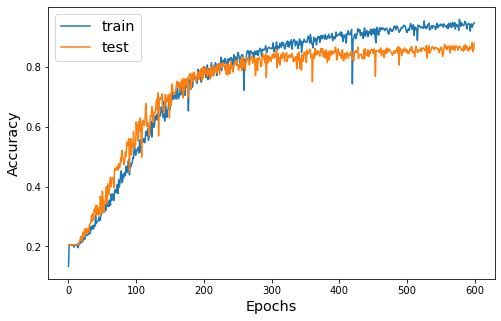

In [26]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy', fontsize='x-large')
plt.xlabel('Epochs', fontsize='x-large')
plt.legend(['train', 'test'], loc='upper left', fontsize='x-large')

In [10]:
from tensorflow import keras
model = keras.models.load_model("C:/Users/vaibh/LFW_Face_Recognition/CNN-classes=42_funneled_UPDATED.h5")

In [11]:
y_pred = model.predict(X_test, batch_size=len(X_test), verbose=1)
y_pred = np.argmax(y_pred, axis=1)

1/1 [==============================] - 0s 998us/step


In [12]:
y_pred_class = keras.utils.to_categorical(y_pred, n_classes)

In [14]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(0, len(classes), 2)
    plt.xticks(tick_marks, classes[tick_marks], rotation=90)
    plt.yticks(tick_marks, classes[tick_marks])
    plt.ylabel('True label', fontsize='x-large')
    plt.xlabel('Predicted label', fontsize='x-large')

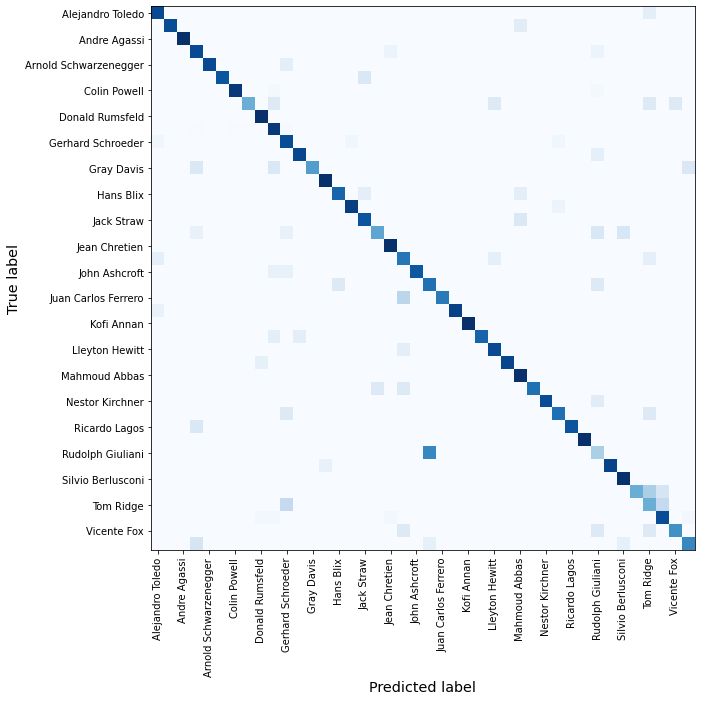

In [15]:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm, classes=target_names)
plt.grid(False)

In [16]:
def plot_barh(labels, values):
    fig = plt.figure(figsize=(12, 8))
    y_pos = np.arange(len(labels))
    plt.barh(y_pos, values, align='center', alpha=0.5)
    plt.yticks(y_pos, labels)
    plt.xticks(np.arange(0.0, 1.0, 0.05))
    plt.xlabel('Accuracy', fontsize='x-large')
    plt.ylabel('Classes', fontsize='x-large')
    plt.axes().xaxis.grid(color='black', linestyle='-', linewidth=0.5)
    axes = plt.gca()
    axes.set_xlim([0.0, 1.0])
    axes.axvline(np.mean(values), color='green', linewidth=2)
    plt.tight_layout()

<ipython-input-16-9c06cbbf5867>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.grid(color='black', linestyle='-', linewidth=0.5)


Average Accuracy: 82.5%


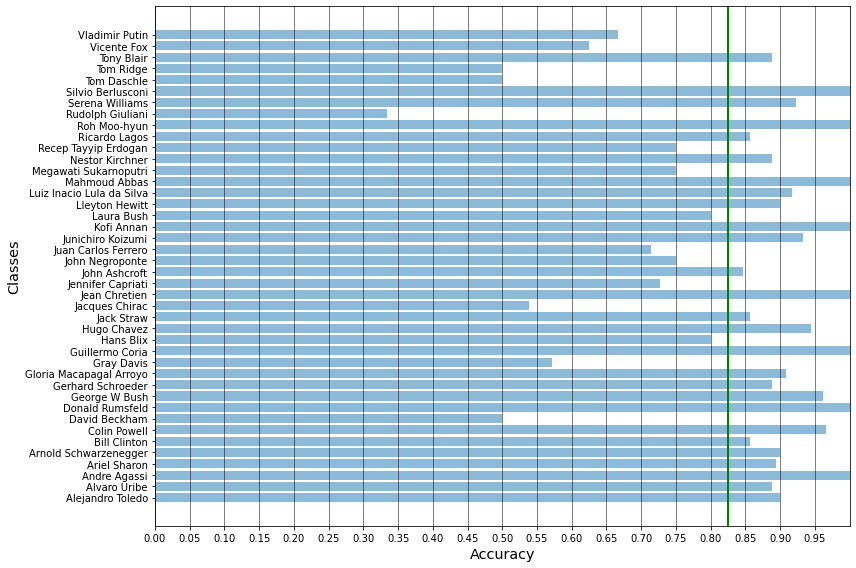

In [17]:
class_accuracies = [cm[i, i] for i in range(cm.shape[0])]
plot_barh(target_names, class_accuracies)
print('Average Accuracy: {}%'.format(np.round(np.mean(class_accuracies) * 100.0, 1)))

In [8]:
def plot_barh_f1(labels, values):
    fig = plt.figure(figsize=(12, 8))
    y_pos = np.arange(len(labels))
    plt.barh(y_pos, values, align='center', alpha=0.5)
    plt.yticks(y_pos, labels)
    plt.xticks(np.arange(0.0, 1.0, 0.05))
    plt.xlabel('F1 Score', fontsize='x-large')
    plt.ylabel('Class', fontsize='x-large')
    plt.axes().xaxis.grid(color='black', linestyle='-', linewidth=0.5)
    axes = plt.gca()
    axes.set_xlim([0.0, 1.0])
    axes.axvline(0.88, color='green', linewidth=2)
    plt.tight_layout()

<ipython-input-8-2105912e01a9>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.grid(color='black', linestyle='-', linewidth=0.5)


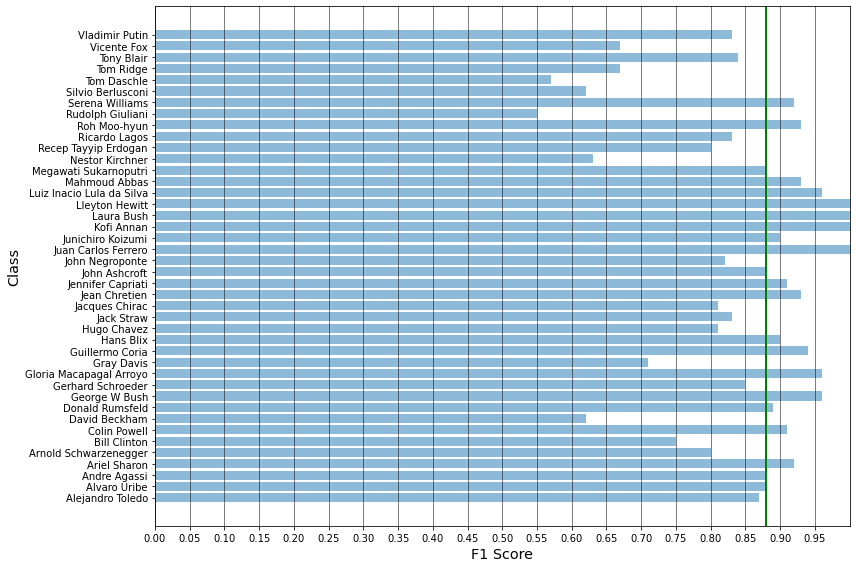

In [9]:
f1_scores = [0.87, 0.88, 0.88, 0.92, 0.80, 0.75, 0.91, 0.62, 0.89, 0.96, 0.85, 0.96, 0.71, 0.94, 0.90, 0.81, 0.83, 0.81, 0.93, 0.91, 0.88, 0.82, 1.00, 0.90, 1.00, 1.00, 1.00, 0.96, 0.93, 0.88, 0.63, 0.80, 0.83, 0.93, 0.55, 0.92, 0.62, 0.57, 0.67, 0.84, 0.67, 0.83]
plot_barh_f1(target_names, f1_scores)

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       1.00      0.89      0.94         9
           2       1.00      1.00      1.00         9
           3       0.74      0.89      0.81        19
           4       1.00      0.90      0.95        10
           5       1.00      0.86      0.92         7
           6       0.98      0.97      0.97        59
           7       0.80      0.50      0.62         8
           8       0.94      1.00      0.97        30
           9       0.96      0.96      0.96       133
          10       0.75      0.89      0.81        27
          11       0.91      0.91      0.91        11
          12       1.00      0.57      0.73         7
          13       0.89      1.00      0.94         8
          14       0.89      0.80      0.84        10
          15       0.94      0.94      0.94        18
          16       0.75      0.86      0.80         7
          17       0.88    